In [1]:
import matplotlib.pyplot as plt      #importing all the good stuff
import numpy as np
import vegas
import utils.alphas, utils.analysis, utils.vector, utils.particle, utils.shower,utils.histogram, utils.yoda


In [2]:
##defining all the constants used
alpha= 1/129
alpha_MZ=0.118
M_Z=91.2 
Gamma_Z= 2.5  
sinthw=0.223 #squared weinberg angle
Q={'e':-1,'u':2/3,'c':2/3,'d':-1/3,'s':-1/3,'b':-1/3}      #
T={'u':1/2,'c':1/2,'e':-1/2,'d':-1/2,'s':-1/2,'b':-1/2}    #getting all the flavours and corresponding charges and spins
Flavours=['u','d','c','s','b'] #flavour with a 'u' to flex on them americans
Q_e=-1
Q_uc=2/3
Q_dsb=-1/3
T_uc=1/2
T_edsb=-1/2
N_q=5
N_C=3
f_conv=3.89379656e8
kappa=1/(4*sinthw*(1-sinthw))

normi = (np.arctan(6 + 9 * Gamma_Z / M_Z) + np.arctan(6 - 9 * Gamma_Z / M_Z)) / (M_Z * Gamma_Z)  #normalisation constant for importance sampling

In [3]:
#defining the functions used

#defining the X functions depending on s
def X_1(s):
    res=kappa*s*(s-M_Z**2)/((s-M_Z**2)**2+Gamma_Z**2*M_Z**2) 
    return res

def X_2(s):
    res=kappa**2*s**2/((s-M_Z**2)**2+Gamma_Z**2*M_Z**2)
    return res


#calculating matrix element from given parameters
def M(q,s,cos_theta,phi):
    Q_q=Q[q]
    V_q=T[q]-2*Q_q*sinthw
    A_q=T[q]
    V_e=T['e']-2*Q_e*sinthw
    A_e=T['e']
    a=(1+cos_theta**2)*(Q_e**2*Q_q**2+2*Q_e*Q_q*V_e*V_q*X_1(s) +(A_e**2+V_e**2)*(A_q**2+V_q**2)*X_2(s))
    b=cos_theta*(4*Q_e*Q_q*A_e*A_q*X_1(s) +8*A_e*V_e*A_q*V_q*X_2(s))
    return (4*alpha*np.pi)**2*N_C*(a+b)

#summing M through flavours
def sum1_M(s,cos_theta,phi):
    res=0
    for i in Flavours:
        res+=M(i,s,cos_theta,phi)
    return res

#calculating differential cross-section
def Cross_section(cos_theta,s=M_Z**2):
    return f_conv*1/(4*np.pi*8*np.pi*2*s)*sum1_M(s,cos_theta,0) *2*np.pi #after phi integration    #already using s=MZ**2

def Cross_section_vegas(args):
    cos_theta,s=args
    V=(M_Z+3*Gamma_Z)**2-(M_Z-3*Gamma_Z)**2
    return 1/V*f_conv*1/(4*np.pi*8*np.pi*2*s)*sum1_M(s,cos_theta,0) *2*np.pi #after phi integration    #already using s=MZ**2


#MC-Integration for the integrated cross-section using explicit sum
def integrated_cross_section(N):
    np.random.seed(40)    #defining fixed seed for random numbers
    integral=0
    variance=0
    
    for i in range(N):
        x=2*np.random.random()-1
        A=Cross_section(x)
        integral+=A/N
        variance+=A**2/N
    #returning the integral and MC estimate of the standard deviation     
    return 2*integral, 2*np.sqrt((variance-integral**2 )/N)    #factor of 2 from volume of cos_theta sampling  

#MC-Integration for the integrated cross-section, but with random flavours 
def integrated_cross_section_rf(N,s=M_Z**2):
    np.random.seed(40)
    integral=0
    variance=0
    
    for i in range(N):
        x=2*np.random.random()-1
        q=np.random.choice(Flavours)  #choosing random flavour
        A=N_q* f_conv*1/(4*np.pi*8*np.pi*2*s)*M(q,s,x,0) *2*np.pi  #adding a factor of N_q =5
        integral+=A/N
        variance+=A**2/N
    #returning the integral and MC estimate of the standard deviation
    return 2*integral, 2*np.sqrt((variance-integral**2 )/N)

#using non-sharp distribution for s
def integrated_cross_section_rf_brems(N):
    np.random.seed(40)
    integral=0
    S=[]
    Weight=[]
    variance=0
    binning=4*(M_Z*3*Gamma_Z)/70             #volume of sampling range divided by number of bins for the histogram
    V=(M_Z+3*Gamma_Z)**2-(M_Z-3*Gamma_Z)**2
    for i in range(N):
        #s=(M_Z-3*Gamma_Z)**2+np.random.random()*((M_Z+3*Gamma_Z)**2-(M_Z-3*Gamma_Z)**2)
        #choosing s from new uniform distribution
        s=(M_Z-3*Gamma_Z)**2+4*np.random.random()*(M_Z*3*Gamma_Z) #pretty sure this is what the algebra works out to be
        x=2*np.random.random()-1
        S.append(s)  #append s for histrogram purposes later on
        q=np.random.choice(Flavours)
        A=N_q* f_conv*1/(4*np.pi*8*np.pi*2*s)*M(q,s,x,0) *2*np.pi
        integral+=A/N
        variance+=A**2/N     
        Weight.append(2*A/(binning*N)*V)    #adjusting the binned weight for the histogram
    #returning stuff as before    
    return 2*integral, 2*np.sqrt((variance-integral**2 )/N),S,Weight



#adjusted for importance sampling
def integrated_cross_section_rf_brems_importance(N):
    np.random.seed(40)
    integral=0
    S=[]
    Weight=[]
    binning=4*(M_Z*3*Gamma_Z)/70
    variance=0
    V=(M_Z+3*Gamma_Z)**2-(M_Z-3*Gamma_Z)**2
    rho_max,rho_min=G((M_Z+3*Gamma_Z)**2),G((M_Z-3*Gamma_Z)**2)    #getting transformed boundary 
    V_rho=(rho_max-rho_min)
    
    for i in range(N):
        a=np.random.random()
        s=G_inv(rho_min+a*(rho_max-rho_min)    )
        x=2*np.random.random()-1
        S.append(s)                       #append s for histrogram purposes later on
        q=np.random.choice(Flavours)
        A=N_q* f_conv*1/(4*np.pi*8*np.pi*2*s)*M(q,s,x,0) *2*np.pi*1/g(s)
        integral+=A/N
        variance+=A**2/N      
        Weight.append(2*A/(binning*N)*V)
    #returning stuff as before    
    return 2*integral/V, 2*np.sqrt((variance-integral**2 )/N)/V,S,Weight

#defining functions for importance sampling
def g(x):
    return 1/((x-M_Z**2)**2+M_Z**2*Gamma_Z**2)*1/((normi))

def G(x):
    return np.arctan((x-M_Z**2)/(M_Z*Gamma_Z))/((normi)*(M_Z*Gamma_Z))

def G_inv(x):
    return M_Z*Gamma_Z*np.tan(x*normi*(M_Z*Gamma_Z))+M_Z**2

In [4]:
#computing integrated cross-section for different N
n=np.arange(10,10000,10)
y1=np.array([integrated_cross_section(i) for i in n])
y2=np.array([integrated_cross_section_rf(i) for i in n])


In [5]:
#write data into file#
pathI='Data/integratedcrosssection'
file = open(pathI+".txt","w")
file.write('integrated cross section explicit summation          standard deviation \n \n')

for i in y1:
    file.write(str(i)+'\n')
    
file.write('\n \n')
file.write('integrated cross section with random flavour           standard deviation \n \n')

for i in y2:
    file.write(str(i)+'\n')
file.close()


[42305.84692767   116.44915538] random flavour: [42135.39714127   127.3368279 ]
(42244.27917388788, 36.625729883651594)
(42254.32673015199, 40.296988904034464)


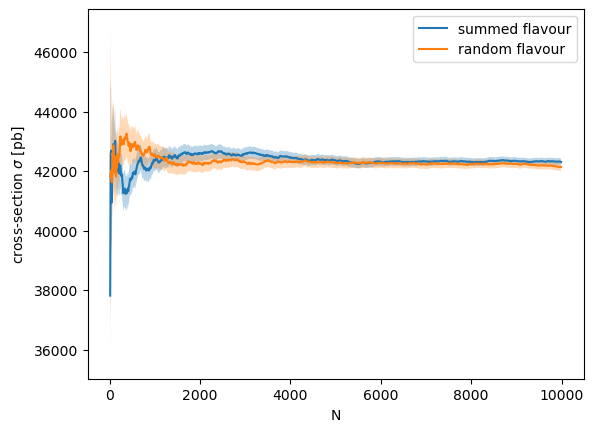

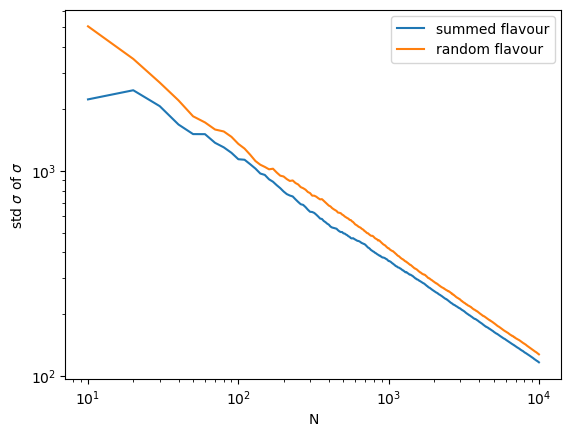

In [6]:
#1b)
#plotting cross section and std vs N
print(y1[-1],'random flavour:',y2[-1])
print(integrated_cross_section(100000))
print(integrated_cross_section_rf(100000))

plt.plot(n,y1[:,0],label='summed flavour')
plt.fill_between(n,y1[:,0]+y1[:,1],y1[:,0]-y1[:,1],alpha=0.3)
plt.plot(n,y2[:,0],label='random flavour')
plt.fill_between(n,y2[:,0]+y2[:,1],y2[:,0]-y2[:,1],alpha=0.3)
plt.legend()
plt.xlabel('N')
plt.ylabel(r'cross-section $\sigma$ [pb]')
#plt.savefig('Plots/MClong.png')
plt.show()

plt.loglog(n,y1[:,1],label='summed flavour')
plt.loglog(n,y2[:,1],label='random flavour')
plt.xlabel('N')
plt.ylabel(r'std $\sigma$ of $\sigma$')
plt.legend()
#plt.savefig('Plots/stdlong.png')
plt.show()

In [7]:
#1c) plotting cross section with bremsstrahlung
n=np.arange(10,10000,10)
y3=np.array([integrated_cross_section_rf_brems(i)[0:2] for i in n])

(9908.537875659455, 39.54358864986537)


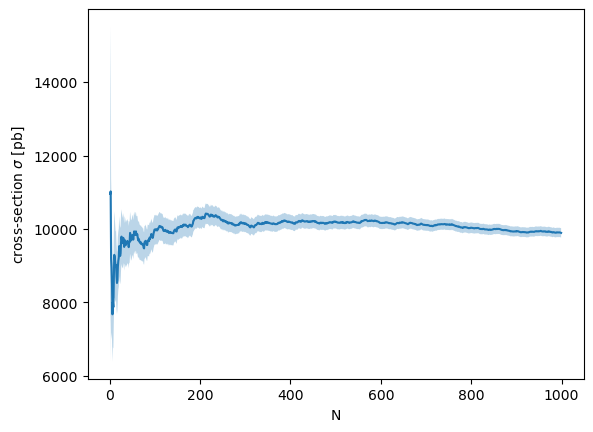

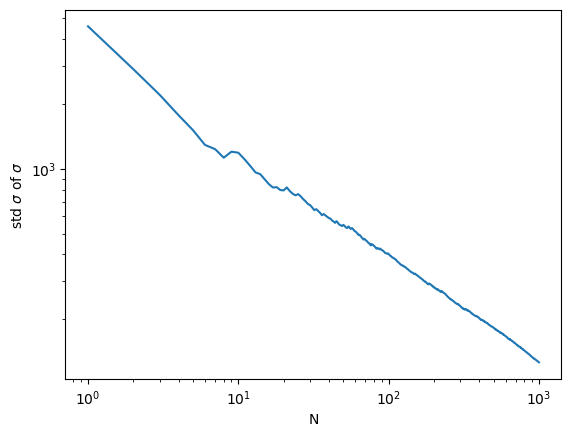

In [31]:
#1d)
#plotting  cross section and std vs N with uniformly distributed s
pathB='Data/crosssectionbrems'
file = open(pathB+".txt","w")
file.write('integrated cross section explicit summation          standard deviation \n \n')

for i in y3:
    file.write(str(i)+'\n')
    
file.write('\n \n')
file.close()
plt.plot(n[1:],y3[:,0])
plt.fill_between(n[1:],y3[:,0]+y3[:,1],y3[:,0]-y3[:,1],alpha=0.3)
print(integrated_cross_section_rf_brems(100000)[0:2])
plt.xlabel('N')
plt.ylabel(r'cross-section $\sigma$ [pb]')
#plt.savefig('Plots/brems.png')
plt.show()

plt.loglog(n[1:],y3[:,1])
plt.xlabel('N')
plt.ylabel(r'std $\sigma$ of $\sigma$')

#plt.savefig('Plots/stdy3long.png')
plt.show()


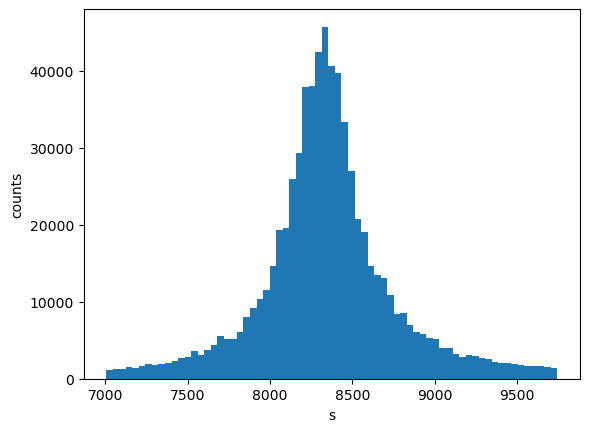

In [32]:
#histogram of s with MC-weights
A=integrated_cross_section_rf_brems(10000)

#print(A)
pathH='Data/hist'
file = open(pathH+".txt","w")
file.write('s          recorded weight \n \n')

for i in range(len(A[3])):
    file.write(str(A[2][i])+'       '+str(A[3][i])+'\n')

    
file.write('\n \n')
u= (M_Z-3*Gamma_Z)**2+4*np.linspace(0,1,70)*(M_Z*3*Gamma_Z)
plt.hist(A[2],bins=u,weights=A[3])
plt.xlabel('s')
plt.ylabel('counts')
plt.savefig('Plots/Hist.png')
plt.show()

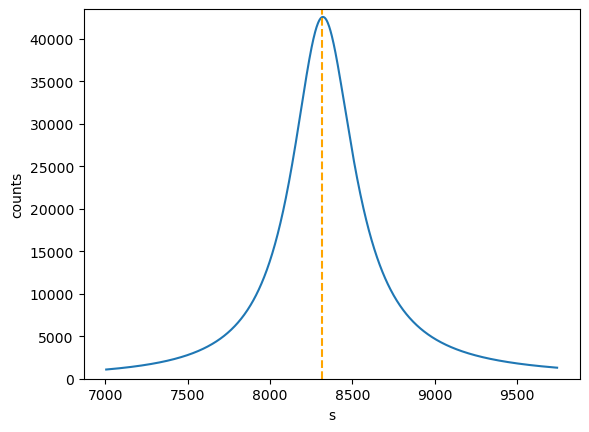

In [33]:
#scanning different fixed s values
t= (M_Z-3*Gamma_Z)**2+4*np.linspace(0,1,1000)*(M_Z*3*Gamma_Z)
y_s=[integrated_cross_section_rf(1000,i)[0] for i in t]

plt.plot(t,y_s)
plt.vlines(M_Z**2,0,44000,colors='orange',linestyles='dashed')
plt.ylim(0,43500)
plt.xlabel('s')
plt.ylabel('counts')

plt.show()

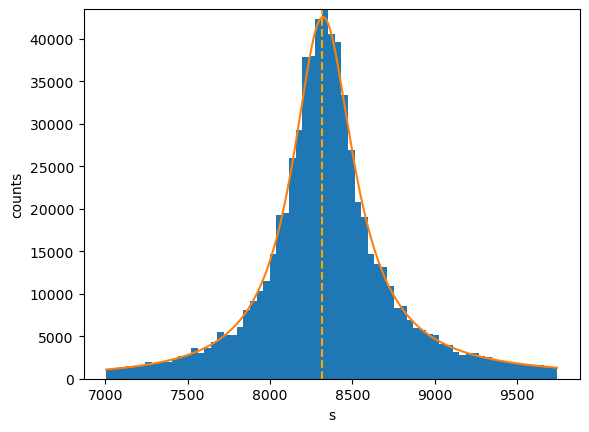

In [34]:
#plotting curve and histogram to see correspondence
plt.hist(A[2],bins=u,weights=A[3])
plt.plot(t,y_s)
plt.xlabel('s')
plt.ylabel('counts')
plt.vlines(M_Z**2,0,44000,colors='orange',linestyles='dashed')
plt.ylim(0,43500)
plt.show()

itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   9906(108)       9906(108)           0.00     1.00
  2   9927(54)        9923(48)            0.03     0.86
  3   9928(41)        9926(31)            0.02     0.98
  4   9930(30)        9928(22)            0.02     1.00
  5   9932(28)        9929(17)            0.02     1.00
  6   9928(23)        9929(14)            0.01     1.00
  7   9951(21)        9936(12)            0.14     0.99
  8   9959(18)        9942.8(9.7)         0.30     0.95
  9   9925(16)        9938.2(8.3)         0.37     0.94
 10   9930(14)        9936.2(7.1)         0.36     0.96



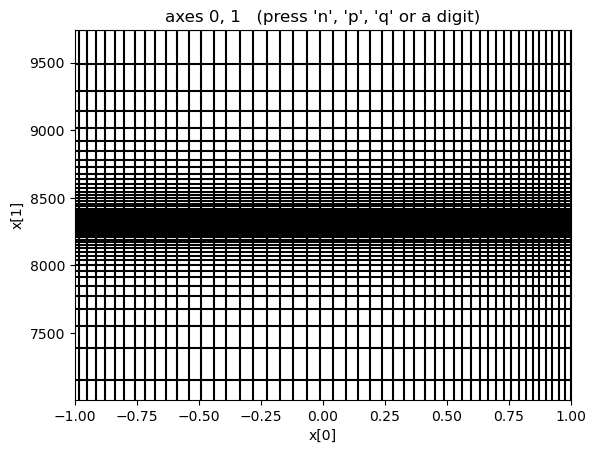

In [36]:
#1e)
#using the VEGAS integrator to calculate total cross section
integ = vegas.Integrator([[-1,1],[ (M_Z-3*Gamma_Z)**2, (M_Z+3*Gamma_Z)**2]])
result = integ(Cross_section_vegas, nitn=10, neval=1000)
print(result.summary())

#plt.savefig('Plots/Hist.png')
integ.map.show_grid()

In [37]:
#1f) and 1g)
A_1=integrated_cross_section_rf_brems(10000)
A_2=integrated_cross_section_rf_brems_importance(10000)        #comparing uniform and importance sampling of s
print(A_1[0],A_2[0])
print(A_1[1],A_2[1])
print(A_1[1]/A_2[1])

9905.174756386014 9940.506190525757
126.32008729167734 31.761313224513685
3.977168273828876


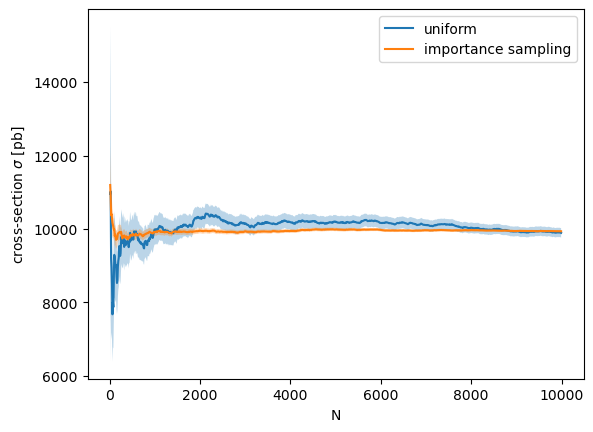

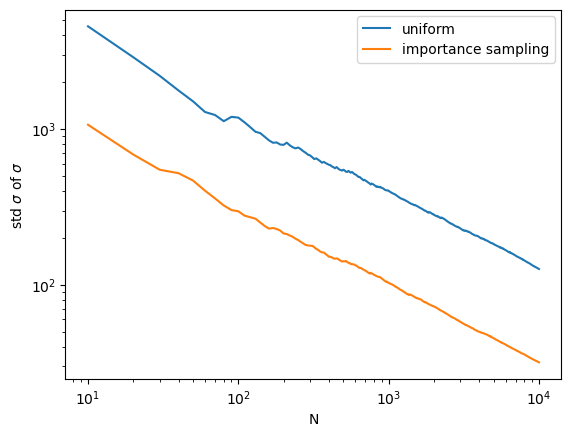

In [38]:
#comparing uniform and importance sampling of s, but in a plot this time

n=np.arange(10,10000,10)
ybrems1=np.array([integrated_cross_section_rf_brems(i)[0:2] for i in n])
ybrems2=np.array([integrated_cross_section_rf_brems_importance(i)[0:2] for i in n])

pathS='Data/importancesampling'
file = open(pathS+".txt","w")
file.write('integrated cross section (uniform)          standard deviation \n \n')

for i in ybrems1:
    file.write(str(i)+'\n')
    
file.write('\n'+'integrated cross section (importance sampling)          standard deviation \n \n')

for i in ybrems2:
    file.write(str(i)+'\n')
    
    
file.close()

plt.plot(n,ybrems1[:,0],label='uniform')
plt.fill_between(n,ybrems1[:,0]+ybrems1[:,1],ybrems1[:,0]-ybrems1[:,1],alpha=0.3)
plt.plot(n,ybrems2[:,0],label='importance sampling')
plt.fill_between(n,ybrems2[:,0]+ybrems2[:,1],ybrems2[:,0]-ybrems2[:,1],alpha=0.3)
plt.legend()
plt.xlabel('N')
plt.ylabel(r'cross-section $\sigma$ [pb]')
plt.savefig('Plots/importance.png')
plt.show()

plt.loglog(n,ybrems1[:,1],label='uniform')
plt.loglog(n,ybrems2[:,1],label='importance sampling')
plt.ylabel(r'std $\sigma$ of $\sigma$')
plt.xlabel('N')
plt.legend()
plt.savefig('Plots/importancestd.png')
plt.show()

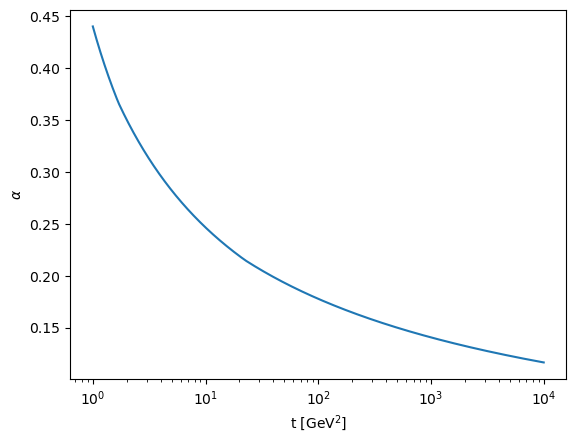

In [39]:
#Task 1.2
#plotting alpha in relation to t
F=utils.alphas.AlphaS(M_Z**2,alpha_MZ)
t=np.logspace(0,4,10000)
plt.semilogx(t,[F(i) for i in t])
plt.xlabel(r't [GeV$^2$]')
plt.ylabel(r'$\alpha$')
plt.savefig('Plots/alpha.png')

In [40]:
#2b)  combining initial scattering event with parton shower
totalcrosssection=42250
particle_number={'d':1,'u':2,'s':3,'c':4,'b':5,'e':11,'g':21}
def parton_shower():
    s=M_Z**2
    x=2*np.random.random()-1               #
    phi=2*np.pi*np.random.random()         #sampling random variables
    q=np.random.choice(Flavours)           #
    
    A=f_conv*N_q*1/(4*np.pi*8*np.pi*2*s)*M(q,s,x,phi) *2*np.pi     #gaining weight
    sinth=np.sqrt(1-x**2)
    p0=np.sqrt(s)/2
    p1=-np.cos(phi)*sinth*p0            #defining momenta
    p2=-np.sin(phi)*sinth*p0
    p3=-x*p0
    p_e=utils.vector.Vec4(p0,0,0,p0)
    p_e_=utils.vector.Vec4(p0,0,0,-p0)
    p_q=utils.vector.Vec4(p0,p1,p2,p3)
    p_antiq=utils.vector.Vec4(p0,-p1,-p2,-p3)
    e1=utils.particle.Particle(11,p_e,[0,0])         #initialising particles
    e2=utils.particle.Particle(-11,p_e_,[0,0])
    q1=utils.particle.Particle(particle_number[q],p_q,[1,0])
    q2=utils.particle.Particle(-particle_number[q],p_antiq,[0,1]) 
    
    shower=utils.shower.Shower(utils.alphas.AlphaS(M_Z**2,alpha_MZ))
    event=[e1,e2,q1,q2]
    shower.run(event,M_Z**2)             #start shower
    return event,2*A/totalcrosssection   #return final particles and MC weight (normalised to total cross section)

In [41]:
#2c) 
#counting particles
numberofparticles=0
result=[]
stdev=[]
var=0
for i in range(1000):
    final_state=parton_shower()         
                                                            ###  remove the first e+ e- interaction wich is always being carried by the list for no real reason 
    numberofparticles+=len(final_state[0][2:])              ##   which gave me significant headaches when debugging  (╯°□°）╯︵ ┻━┻
    var+=len(final_state[0][2:])**2 
    result.append(numberofparticles/(i+1))
    stdev.append(np.sqrt((-result[i]**2+var/(i+1))/(i+1))  )
    
result=np.array(result)
stdev=np.array(stdev)
print(result[-1],r'$\pm$',stdev[-1]) 



5.196 $\pm$ 0.05861385501739331


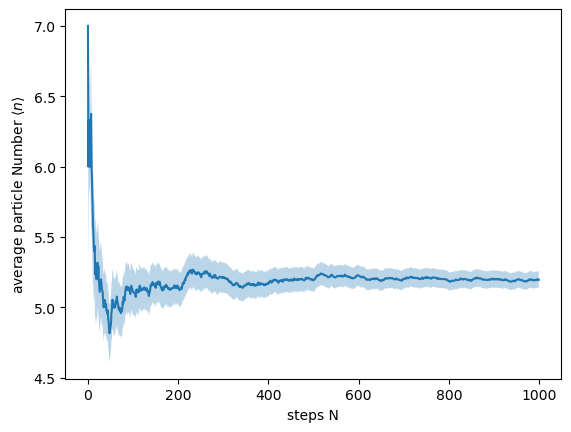

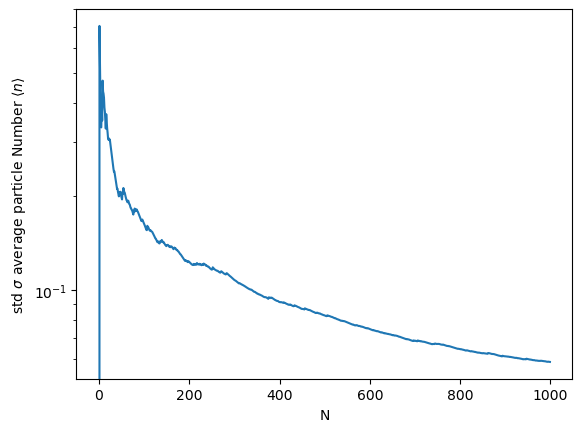

In [42]:
#plotting the evolution of average particle number and std against N 
n=np.arange(1000)
plt.plot(result)
plt.fill_between(n,result+stdev,result-stdev,alpha=0.3)
plt.xlabel('steps N')
plt.ylabel(r'average particle Number $\langle n \rangle$')
plt.savefig('Plots/particlenumber.png')
plt.show()

plt.semilogy(n,stdev)
plt.xlabel('N')
plt.ylabel(r'std $\sigma$ average particle Number $\langle n \rangle$')
plt.show()

In [43]:
#1e) generating large number of events and giving it to adjusted analyze class
jet=utils.analysis.Analysis()
for i in range(10000):
    AAAAH=parton_shower()
    jet.analyze(AAAAH[0][2:],AAAAH[1]*totalcrosssection)
jet.finalize('Final_result')  


/home/jovyan/Master/ACP/utils/analysis.py:114: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y=np.array(y)


Plotting (might take a few moments) ...


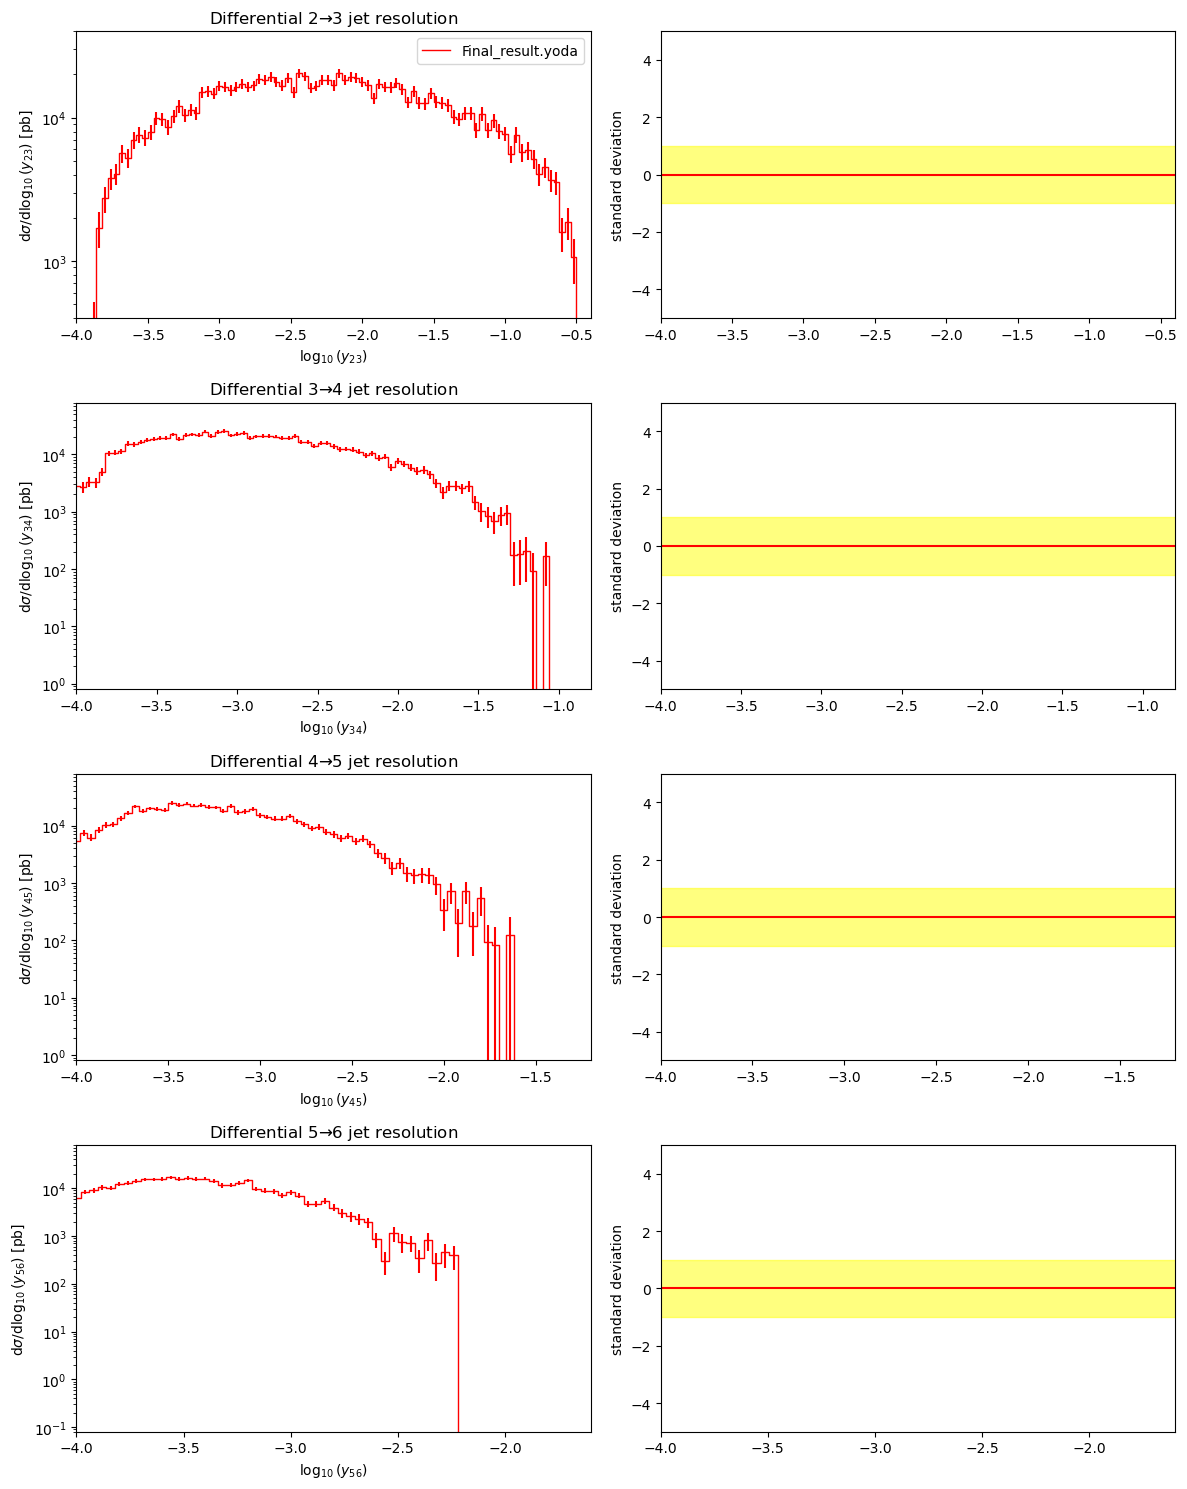

In [ ]:
#plotting the final result
path=['Final_result.yoda']
utils.yoda.plot_jet_histograms(path)
plt.savefig('Gigaplot2.pdf')
plt.show()

Plotting (might take a few moments) ...


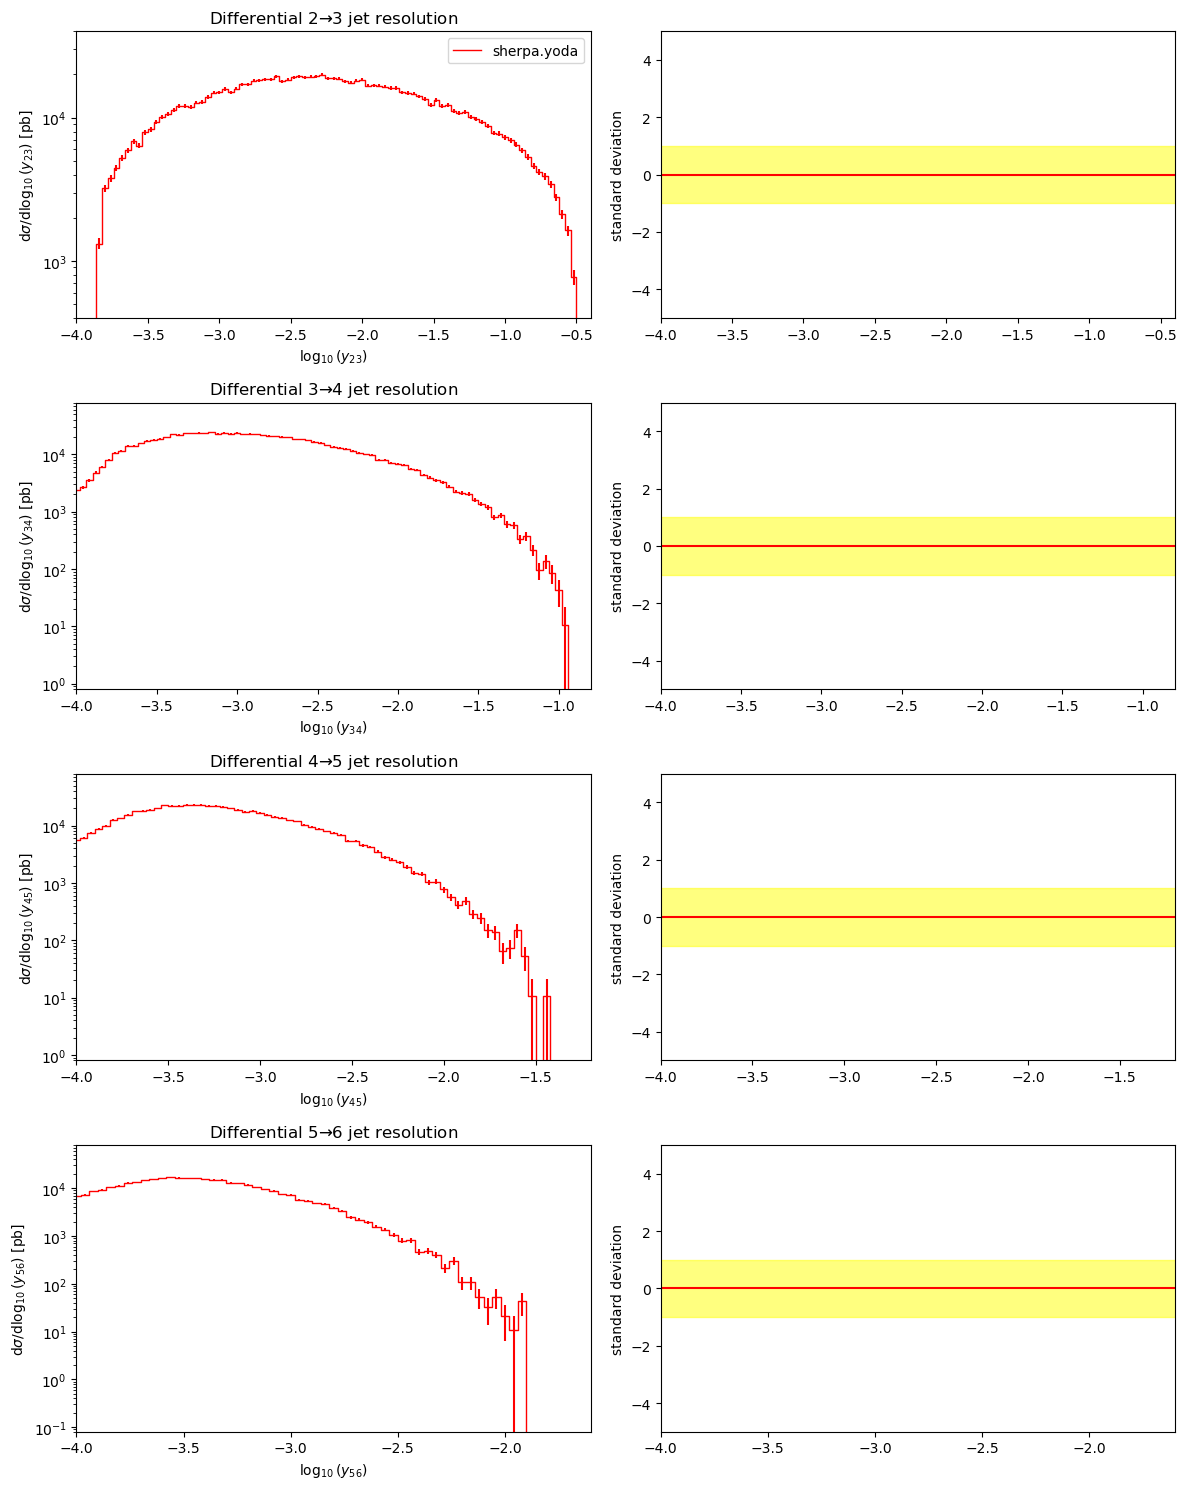

In [ ]:
#comparing it to SHERPA
path2=['sherpa.yoda']
utils.yoda.plot_jet_histograms(path2)
plt.show()

#########  Done  (๑ᵕ⌓ᵕ̤)  ######